<a href="https://colab.research.google.com/github/rajeshwari302/Bharat-Intern/blob/main/Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'titanic-machine-learning-from-disaster:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F12609%2F17243%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240530%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240530T151114Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D08ba3098fe208079f62bc65e1ca389dc76b7e249032f949a83a925a1eb59abdce46625501ff4ce1835897bf4502221d6ba90996735dfc2bc15f12667bcc864266d13f3dce8afc867cd7c7635ed7fe63701bcdb8d1ca778a8d81a9ed0159425b8d44b4001de621aaaa8a0be0bdc715aaee06dfebe64733baf0d764e2963c93e791647456e461b41aa840ec78d31b3c5b9d2af0be0dc00072d7f3bfe251dc2874a89c6b9577765d659d25f73f002ce3bc65c3de4f8ad0729ac9c9ae83a0857b807b9b012356dfc74cc2ac970557c596ba89a46e6ca20c24c12a3dbddb903c9a31c7931e8892303ab3d316c5add45fdc0481503e328c0db3c55578b24d5cd01457d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 34877 bytes downloaded
Downloaded and uncompressed: titanic-machine-learning-from-disaster
Data source import complete.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic-machine-learning-from-disaster/train.csv
/kaggle/input/titanic-machine-learning-from-disaster/gender_submission.csv
/kaggle/input/titanic-machine-learning-from-disaster/test.csv


In [9]:
#import libraries
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import pickle

In [10]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath).set_index("PassengerId")

    # Drop features with high null counts
    df.drop(columns = ["Cabin"], inplace= True)

    #Drop low and high- and low-cardinality categorical variables
    df.drop(columns= ["Name", "Ticket", "Embarked"], inplace=True)

    #Sex feature
    df["Pass_Sex"] = (df["Sex"] == "male").astype(int)
    df.drop(columns = ["Sex"], inplace= True)

    #Drop columns with multicollinearity
    df.drop(columns=["SibSp", "Fare"], inplace=True)

    return df

In [11]:
#Prepare Data - Import Data
df_train = wrangle("../input/titanic-machine-learning-from-disaster/train.csv")
print("df Shape:", df_train.shape)
df_train.head()

df Shape: (891, 5)


,Survived,Pclass,Age,Parch,Pass_Sex
PassengerId,,,,,
1,0,3,22.0,0,1
2,1,1,38.0,0,0
3,1,3,26.0,0,0
4,1,1,35.0,0,0
5,0,3,35.0,0,1


In [12]:
#dealing with missing values
df_train.isnull().sum() / len(df_train)

Survived    0.000000
Pclass      0.000000
Age         0.198653
Parch       0.000000
Pass_Sex    0.000000
dtype: float64

In [13]:
#check the data types
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Age       714 non-null    float64
 3   Parch     891 non-null    int64  
 4   Pass_Sex  891 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 41.8 KB


In [14]:
#Calculate the number of unique values for each non-numeric feature in df
df_train.select_dtypes("object").nunique()

Series([], dtype: float64)

Every row in "Name" and "Ticket" have a unique value. These are clear examples of high-cardinality features that we shouldn’t include in our model. We must modify the wrangle function to drop high-cardinality categorical features.

<Axes: >

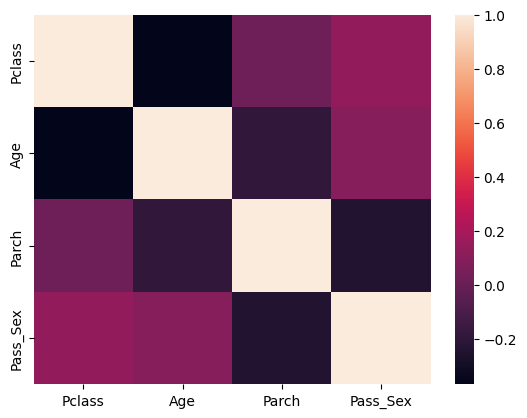

In [15]:
#Plot a correlation heatmap of the remaining numerical features in df
corr = df_train.select_dtypes("number").drop(columns= "Survived").corr()
sns.heatmap(corr)

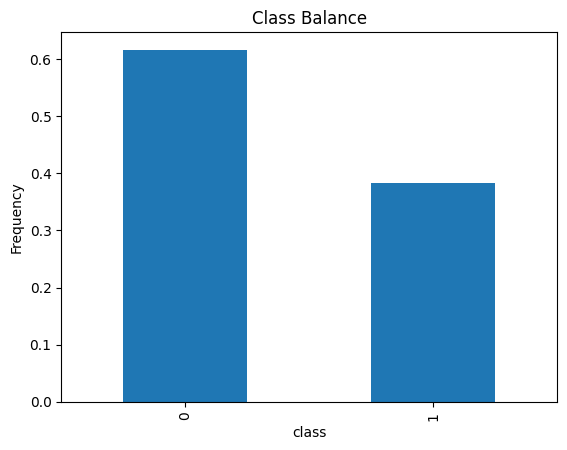

In [16]:
#Check the balance of data
df_train["Survived"].value_counts(normalize= True).plot(
    kind="bar", xlabel="class", ylabel="Frequency", title = "Class Balance");

In [17]:
majority_class_prop, minority_class_prop = df_train["Survived"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)


0.6161616161616161 0.3838383838383838


In [18]:
#Split Data
target = "Survived"
X = df_train.drop(columns = target)
y = df_train[target]
print(X.shape)
print(y.shape)

(891, 4)
(891,)


In [19]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (712, 4)
y_train shape: (712,)
X_test shape: (179, 4)
y_test shape: (179,)


In [20]:
#Build Model - Baseline
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline_Accuracy:", round(acc_baseline, 4))

Baseline_Accuracy: 0.6236


In [21]:
#Build_Model - RandomForest
#Create a pipeline
model = make_pipeline(SimpleImputer(), RandomForestClassifier(random_state=42))
model

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [22]:
#Fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [23]:
#Build Model - Evaluate
#Calculate the training and test accuracy scores for model
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9045
Test Accuracy: 0.7933


In [24]:
#Use a confusion matrix to see how our model performs
y_test.value_counts()

Survived
0    105
1     74
Name: count, dtype: int64

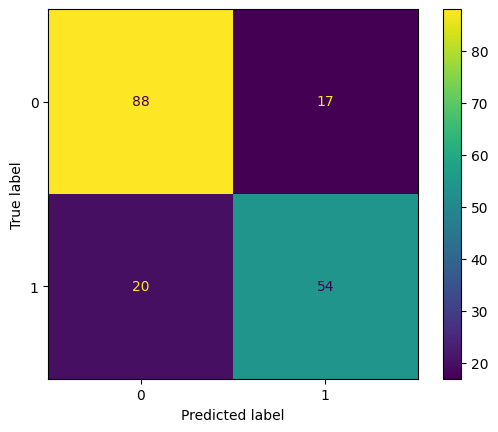

In [25]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

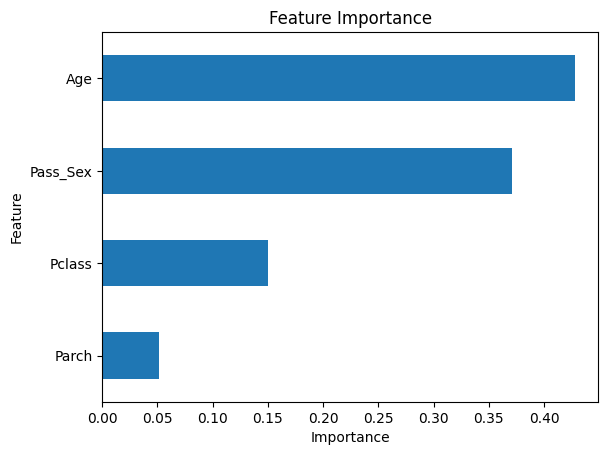

In [26]:
#Create a horizontal bar chart with the most important features for your model
# Get feature names from training data
features = X_train.columns
# Extract importances from model
importances = model.named_steps["randomforestclassifier"].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index= features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind= "barh")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

In [27]:
# Save model
with open("model-titanic.pkl", "wb") as f:
     pickle.dump(model, f)

In [28]:
#Create a function make_predictions
def make_predictions(data_filepath, model_filepath):
   # Wrangle the file
    X_test = wrangle(data_filepath)
   # Load model
    with open(model_filepath, "rb") as f:
         model = pickle.load(f)
   # Generate predictions
    y_test_pred = model.predict(X_test)
   # Put predictions into Series with name "bankrupt", and same index as X_test
    y_test_pred = pd.Series(y_test_pred, index = X_test.index, name ="survived")
    return y_test_pred

In [29]:
y_test_pred = make_predictions( data_filepath="../input/titanic-machine-learning-from-disaster/test.csv",
                        model_filepath="model-titanic.pkl",)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()

predictions shape: (418,)


PassengerId
892    0
893    0
894    1
895    1
896    1
Name: survived, dtype: int64

In [30]:
my_submission = pd.DataFrame(y_test_pred)
my_submission.head()

,survived
PassengerId,
892,0
893,0
894,1
895,1
896,1


In [31]:
my_submission.to_csv("submission.csv")